# Fire hydrants-Shelters analysis in Be'er Sheva
**Doron Laadan 203038708, Eyal Arviv 311264592**

In our project we aim to find intresting insights according to the Be'er Sheva databases of fire hydrants, shelters, and other public facilities. Specifically we did the following:
1. We constructed a network of fire hydrants to see how they connect throught the city and identify isoltead locations that break regulations.
2. We created statistics and a graphical interface to visualize differences between neihborhoods and facilities across the city regarding **fire hydrants** according to a given threshold that concurs with the city's regulations.
3. We created statistics and a graphical interface to visualize differences between neihborhoods and facilities across the city regarding **shelters** according to a given threshold that concurs with the city's regulations.

The notebook is devided into the two following sections: fire hydrants analysis and shelter analysis across the city of Be'er Sheva.

**What does the threshold mean?**

Our graphs are built in the following manner: Each node in the graph represents an object such as gas station, educational institute, etc. In the preprocess phase we calcualted the distance between each of these objects to all of the fire hydrants (or shelters). We only include edges between two nodes in the graph **only** if the distance between them is below the given threshold.

*Imports for the notebook - main is a .py file that is included in the zip of the assingnmet and is required to run this notebook. For comfort and cleaness of this presenation notebook all underline code is there.

In [1]:
%reload_ext autoreload

import importlib
from main import *
import ipywidgets as widgets
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output
from branca.element import Template, MacroElement
style = {'description_width': 'initial'}

We created a visualization for the separation of the neighborhoods in Be'er sheva as we used them in this project.

## Neighborhoods of Be'er Sheva displays

the polygons we used for this project are disply here

In [3]:
import geopandas
import shapely.wkt

neighborhoods_polygons = return_neighborhoods_coordinates()
m = folium.Map(location=[31.2530, 34.7915], tiles='Stamen Terrain',
         zoom_start=13, control_scale=True, prefer_canvas=True)
for nei_name, polygon in neighborhoods_polygons.items():
    reversed_polygon = Polygon([(v[1], v[0]) for v in list(polygon.exterior.coords)])
#     neighborhoods_df = neighborhoods_df.append({'name': nei_name, 'geometry': reversed_polygon, 'isolated_count': neighborhoods_isolated_nodes[nei_name]}, ignore_index=True)
    folium.GeoJson(reversed_polygon).add_to(m)
    folium.LatLngPopup().add_to(m)
    icon = folium.Icon(**{'prefix': 'fa', 'icon': 'arrow-up'})
    folium.Marker([reversed_polygon.centroid.coords[0][1], reversed_polygon.centroid.coords[0][0]], popup=nei_name, icon=icon).add_to(m)
m

# Fire hydrants

First we show the regulations for fire hydrents according to both the law and the head of the south district fire dept' 

In [1]:
from IPython.display import Image
Image(url= "תקנה חשובה.png")

In [2]:
Image(url= "הוראות נציב - מייל.png")

In the next cell we will get the objects that are isolated at least 30 meters from any fire hydrant.

In [4]:
neighborhoods_isolated_nodes = {} # dictionary with the different neighborhoods in Be'er Sheva and the isolated objects in each of the neighborhoods
objects = ['community-centers', 'daycare', 'gas_stations', 'EducationalInstitutions', 'HealthClinics', 'Sport',
            'Synagogue']
neighborhoods = ['Alef', 'Bet', 'Gimel', 'Dalet', 'Hei', 'Vav', 'Tet', 'Ramot', 'Down Town', 'Yod Alef', 'Old Town', 'Ashan',
            'Noi Beka', 'Darom', 'Nahot']
g = create_all_graphs(objects, 'fire_hydrant', 0.03)
for neighborhood in neighborhoods:
    relevant_nodes = nodes_per_neighborhood(g, [neighborhood])
    neighborhoods_isolated_nodes[neighborhood] = len(get_isloated_nodes(g, relevant_nodes))

neighborhoods_df = pd.DataFrame(columns=['name', 'geometry', 'isolated_count'])
for nei_name, polygon in neighborhoods_polygons.items():
    reversed_polygon = Polygon([(v[1], v[0]) for v in list(polygon.exterior.coords)])
    neighborhoods_df = neighborhoods_df.append({'name': nei_name, 'geometry': reversed_polygon, 'isolated_count': neighborhoods_isolated_nodes[nei_name]}, ignore_index=True)

### Neighborhood polygons heatmap according violation of city regulations (30 meter)

The more isolated objects in a neighborhood, the brighter the nighborhood's color.

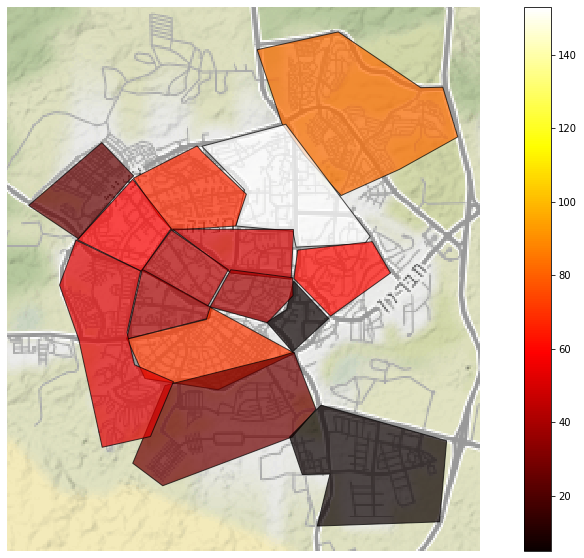

In [5]:
import contextily as ctx

def add_basemap(ax, zoom, url='http://tile.stamen.com/terrain/tileZ/tileX/tileY.png'):
    xmin, xmax, ymin, ymax = ax.axis()
    basemap, extent = ctx.bounds2img(xmin, ymin, xmax, ymax, zoom=zoom, url=url)
    ax.imshow(basemap, extent=extent, interpolation='none')
    # restore original x/y limits
    ax.axis((xmin, xmax, ymin, ymax))
    
neighborhoods_df['isolated_counts'] = neighborhoods_df['isolated_count'].astype(float)
gdf = geopandas.GeoDataFrame(neighborhoods_df, crs={'init' :'epsg:4326'}, geometry = 'geometry').to_crs(epsg=3857)
ax = gdf.plot(column='isolated_counts',figsize=(16, 10), alpha=0.7, cmap='hot',edgecolor='k', legend=True)
add_basemap(ax, zoom=12)
ax.set_axis_off()

## Display public facilities isolated from fire hydrants

In the next cell you can change, using a float slider, the (threshold) distance which above it we consider edges between the different objects, e.g. educational institutes to fire hydrants. Default value is 30 meters as the law states.

In [6]:
distance_threshold = widgets.FloatSlider(
    min=0,
    max=500,
    step=1,
    value=30,
    description='Choose distance threshold (in meters):',
    style=style,
    layout=widgets.Layout(width='50%', height='80px'))
distance_threshold

FloatSlider(value=30.0, description='Choose distance threshold (in meters):', layout=Layout(height='80px', wid…

In the next cell you can choose the types of objects to display in the map

In [8]:
objects_ = widgets.SelectMultiple(    
    options=['community-centers', 'daycare', 'gas_stations', 'EducationalInstitutions', 'HealthClinics', 'Sport',
            'Synagogue'],
    value=['community-centers'],
    rows=7,
    description='Select types of object to display:',
    style=style,
    layout=widgets.Layout(width='40%'),
    disabled=False)
objects_


SelectMultiple(description='Select types of object to display:', index=(0,), layout=Layout(width='40%'), optio…

In the next cell you can choose the neighborhoods to display in the map

In [9]:
neighborhoods_ = widgets.SelectMultiple(    
    options=['Alef', 'Bet', 'Gimel', 'Dalet', 'Hei', 'Vav', 'Tet', 'Ramot', 'Down Town', 'Yod Alef', 'Old Town', 'Ashan',
            'Noi Beka', 'Darom', 'Nahot'],
    value=['Alef'],
    rows=11,
    description='Select neighborhoods to display the objects iny:',
    style=style,
    layout=widgets.Layout(width='40%'),
    disabled=False)
neighborhoods_

SelectMultiple(description='Select neighborhoods to display the objects iny:', index=(0,), layout=Layout(width…

In [10]:
def display_isoltaed_objects_jupyter(ev):
    """
    a function to display Folium map with interactive legend
    :param ev: env variable in notebook
    """
    clear_output()
    display(ev)
    map_ = display_isolated_objects(list(objects_.value), 'fire_hydrant', (distance_threshold.value / 1000), list(neighborhoods_.value))
    

    macro = MacroElement()
    macro._template = Template(return_template_string())

    map_.get_root().add_child(macro)
    display(map_)

In [11]:
button = widgets.Button(description="Display objects")
button.on_click(display_isoltaed_objects_jupyter)
display(button)

Button(description='Display objects', style=ButtonStyle())

## Statistics 

In this section we will present some statistics about the results of isolated objects from fire hydrants given the city regulations.

### All neighborhoods and all facilities according to city regulations (30 meters)

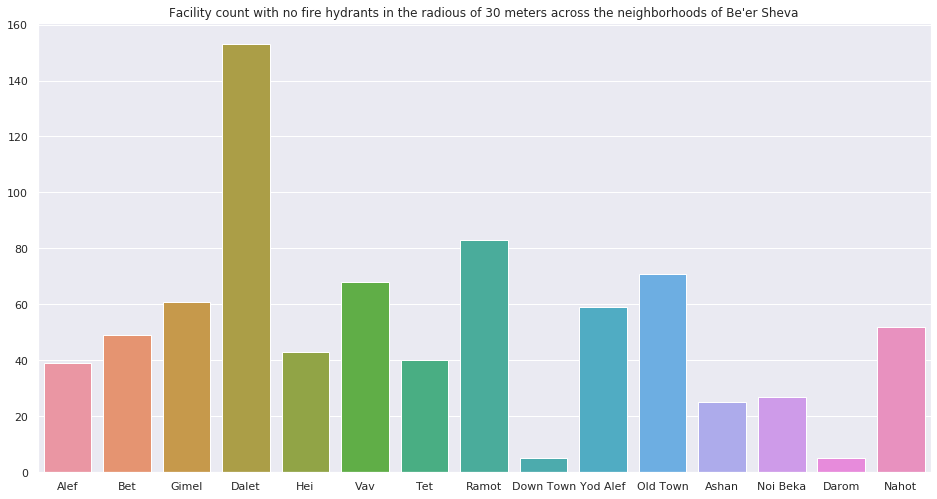

In [12]:
sns.set(rc={'figure.figsize':(16,8.27)})
sns.barplot(x=list(neighborhoods_isolated_nodes.keys()), y=list(neighborhoods_isolated_nodes.values())).set_title('Facility count with no fire hydrants in the radious of 30 meters across the neighborhoods of Be\'er Sheva');

### Isolated facility count across all neighborhoods and all facility types given a chosen threshold (from the above widget)

In [13]:
neighborhood_object_df = pd.DataFrame(columns=['neighborhood', 'object', 'count'])
for object_ in list(objects_.options):
    g = create_all_graphs([object_], 'fire_hydrant', distance_threshold.value / 1000) # 30 meters
    for neighborhood in list(neighborhoods_.options):   
        relevant_nodes = nodes_per_neighborhood(g, [neighborhood])
        neighborhood_object_df = neighborhood_object_df.append({'neighborhood': neighborhood, 'object': object_, 'count': len(get_isloated_nodes(g, relevant_nodes))}, ignore_index=True)

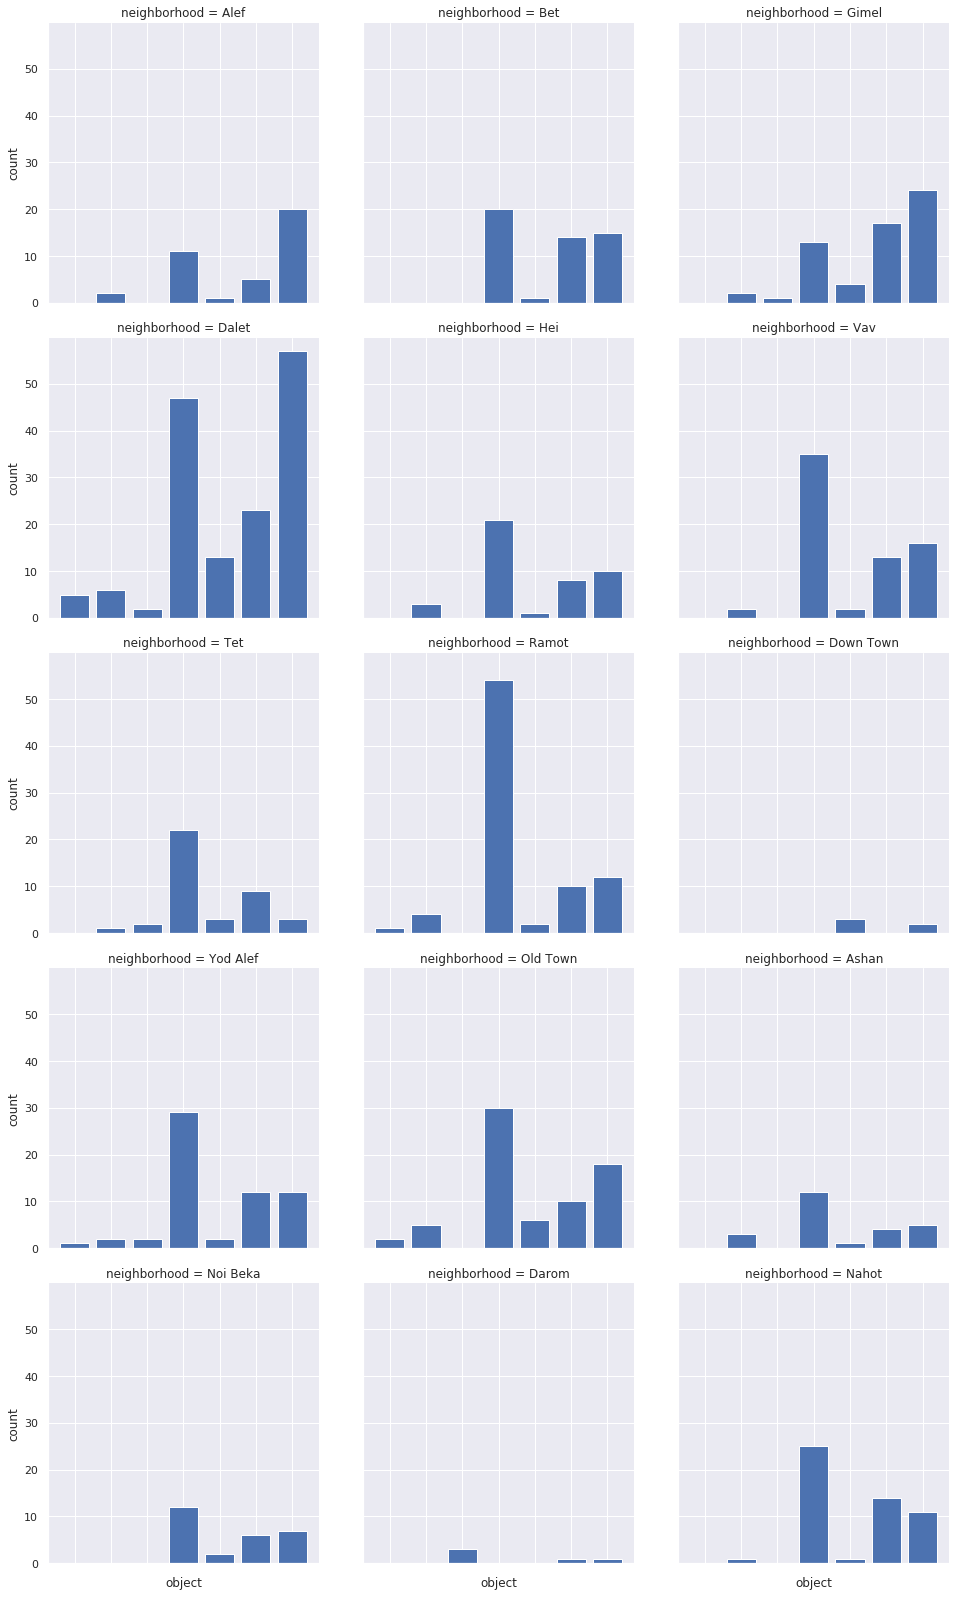

In [14]:
# facetgrid plot
g = sns.FacetGrid(neighborhood_object_df, col="neighborhood", col_wrap=3, height=4.5)
g.map(plt.bar, "object", "count")
g.fig.tight_layout()
g.set_xticklabels(rotation=45);

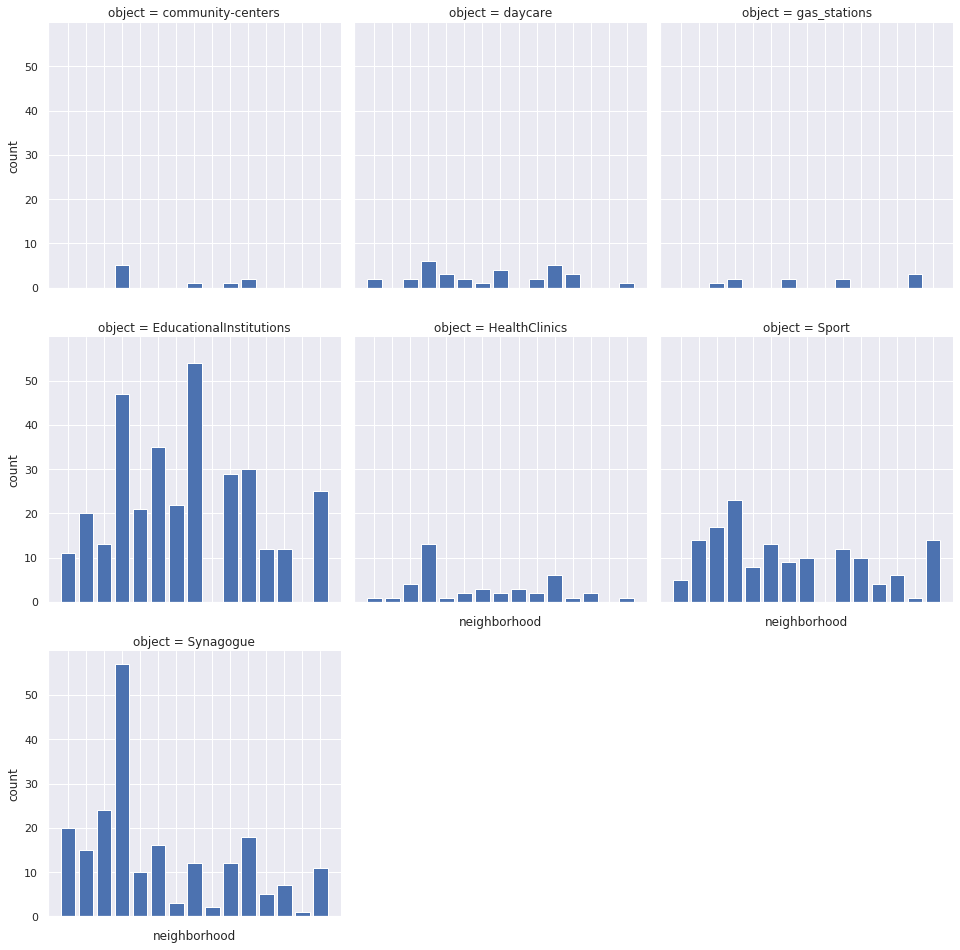

In [15]:
g = sns.FacetGrid(neighborhood_object_df, col="object", col_wrap=3, height=4.5)
g.map(plt.bar, "neighborhood", "count")
g.fig.tight_layout()
g.set_xticklabels(rotation=45);

## Heatmap of public facilities isolated from fire hydrants

**Specified by the above chosen threshold**

In [16]:
from folium.plugins import HeatMap
g = create_all_graphs(list(objects_.options), 'fire_hydrant', distance_threshold.value / 1000)
relevant_nodes = nodes_per_neighborhood(g, list(neighborhoods_.options))
isolated_list = get_isloated_nodes(g, relevant_nodes)
isolated_coordinates = [(g.nodes[node]['x'][1], g.nodes[node]['x'][0]) for node in isolated_list]
m = folium.Map(location=[31.2530, 34.7915], tiles='Stamen Terrain',
         zoom_start=13, control_scale=True, prefer_canvas=True)
HeatMap(isolated_coordinates).add_to(m)
m

## Finding central fire hydrants
Using centrality measure to identify the most important fire hydrants.
* Pressing the button for the first time might take a while (less than one minute) due to computations. Changing the number of important hydrants and reclicking the button will be immediate

In [17]:
top_fire_hydrants_num = widgets.IntText(
    value=10,
    description='Enter number of most important fire hydrants:',
    disabled=False,
    style=style,
    layout=widgets.Layout(width='35%')
)
top_fire_hydrants_num

IntText(value=10, description='Enter number of most important fire hydrants:', layout=Layout(width='35%'), sty…

In [18]:
def all_top_central_fire_hydrants():
    """
    This function retrieves the sorted betweeness centrality object of all the fire hydrants to all of the other object types.
    """
    g = create_all_graphs(list(objects_.options), 'fire_hydrant', 0.03)
    bet_cen = nx.betweenness_centrality(g)
    bet_cen = {k: v for k, v in bet_cen.items() if k < 2596}
    top_hydrants = sorted(bet_cen, key=bet_cen.get, reverse=True)
    poses = nx.get_node_attributes(g, 'x')
    return top_hydrants, poses, bet_cen

In [19]:
def get_top_central_fire_hydrants(n=10):
    """
    Displays a map with the top n fire hydrants according to betweeness centrality measure.
    """
    global bet_cen, poses, top_hydrants
    try:
        bet_cen
    except:
        top_hydrants, poses, bet_cen = all_top_central_fire_hydrants()
    m = folium.Map(location=[31.2530, 34.7915], tiles='Stamen Terrain',
                 zoom_start=13, control_scale=True, prefer_canvas=True)
    for node in top_hydrants[:n]:
        icon = folium.Icon(**{'prefix': 'fa', 'color': 'red', 'icon': 'arrow-up'})
        folium.Marker([poses[node][1], poses[node][0]], popup=str(bet_cen[node]), icon=icon).add_to(m)
    return m
    
def display_fire_hydrants(ev):
    """
    Display the map using the button below.
    """
    clear_output()
    display(ev)
    m = get_top_central_fire_hydrants(top_fire_hydrants_num.value)
    display(m)

In [20]:
button = widgets.Button(description="Display fire hydrants")
button.on_click(display_fire_hydrants)
display(button)

Button(description='Display fire hydrants', style=ButtonStyle())

## Fire hydrants - networkx visualization

This section shows visualization of the network comprised of only fire hydrant nodes.

### Basic fire hydrants only network with 30 meters threshold

/data/home/eyalar/anaconda3/envs/bigdata_venv/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:563: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/data/home/eyalar/anaconda3/envs/bigdata_venv/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: 
The is_numlike function was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use isinstance(..., numbers.Number) instead.
  if cb.is_numlike(alpha):


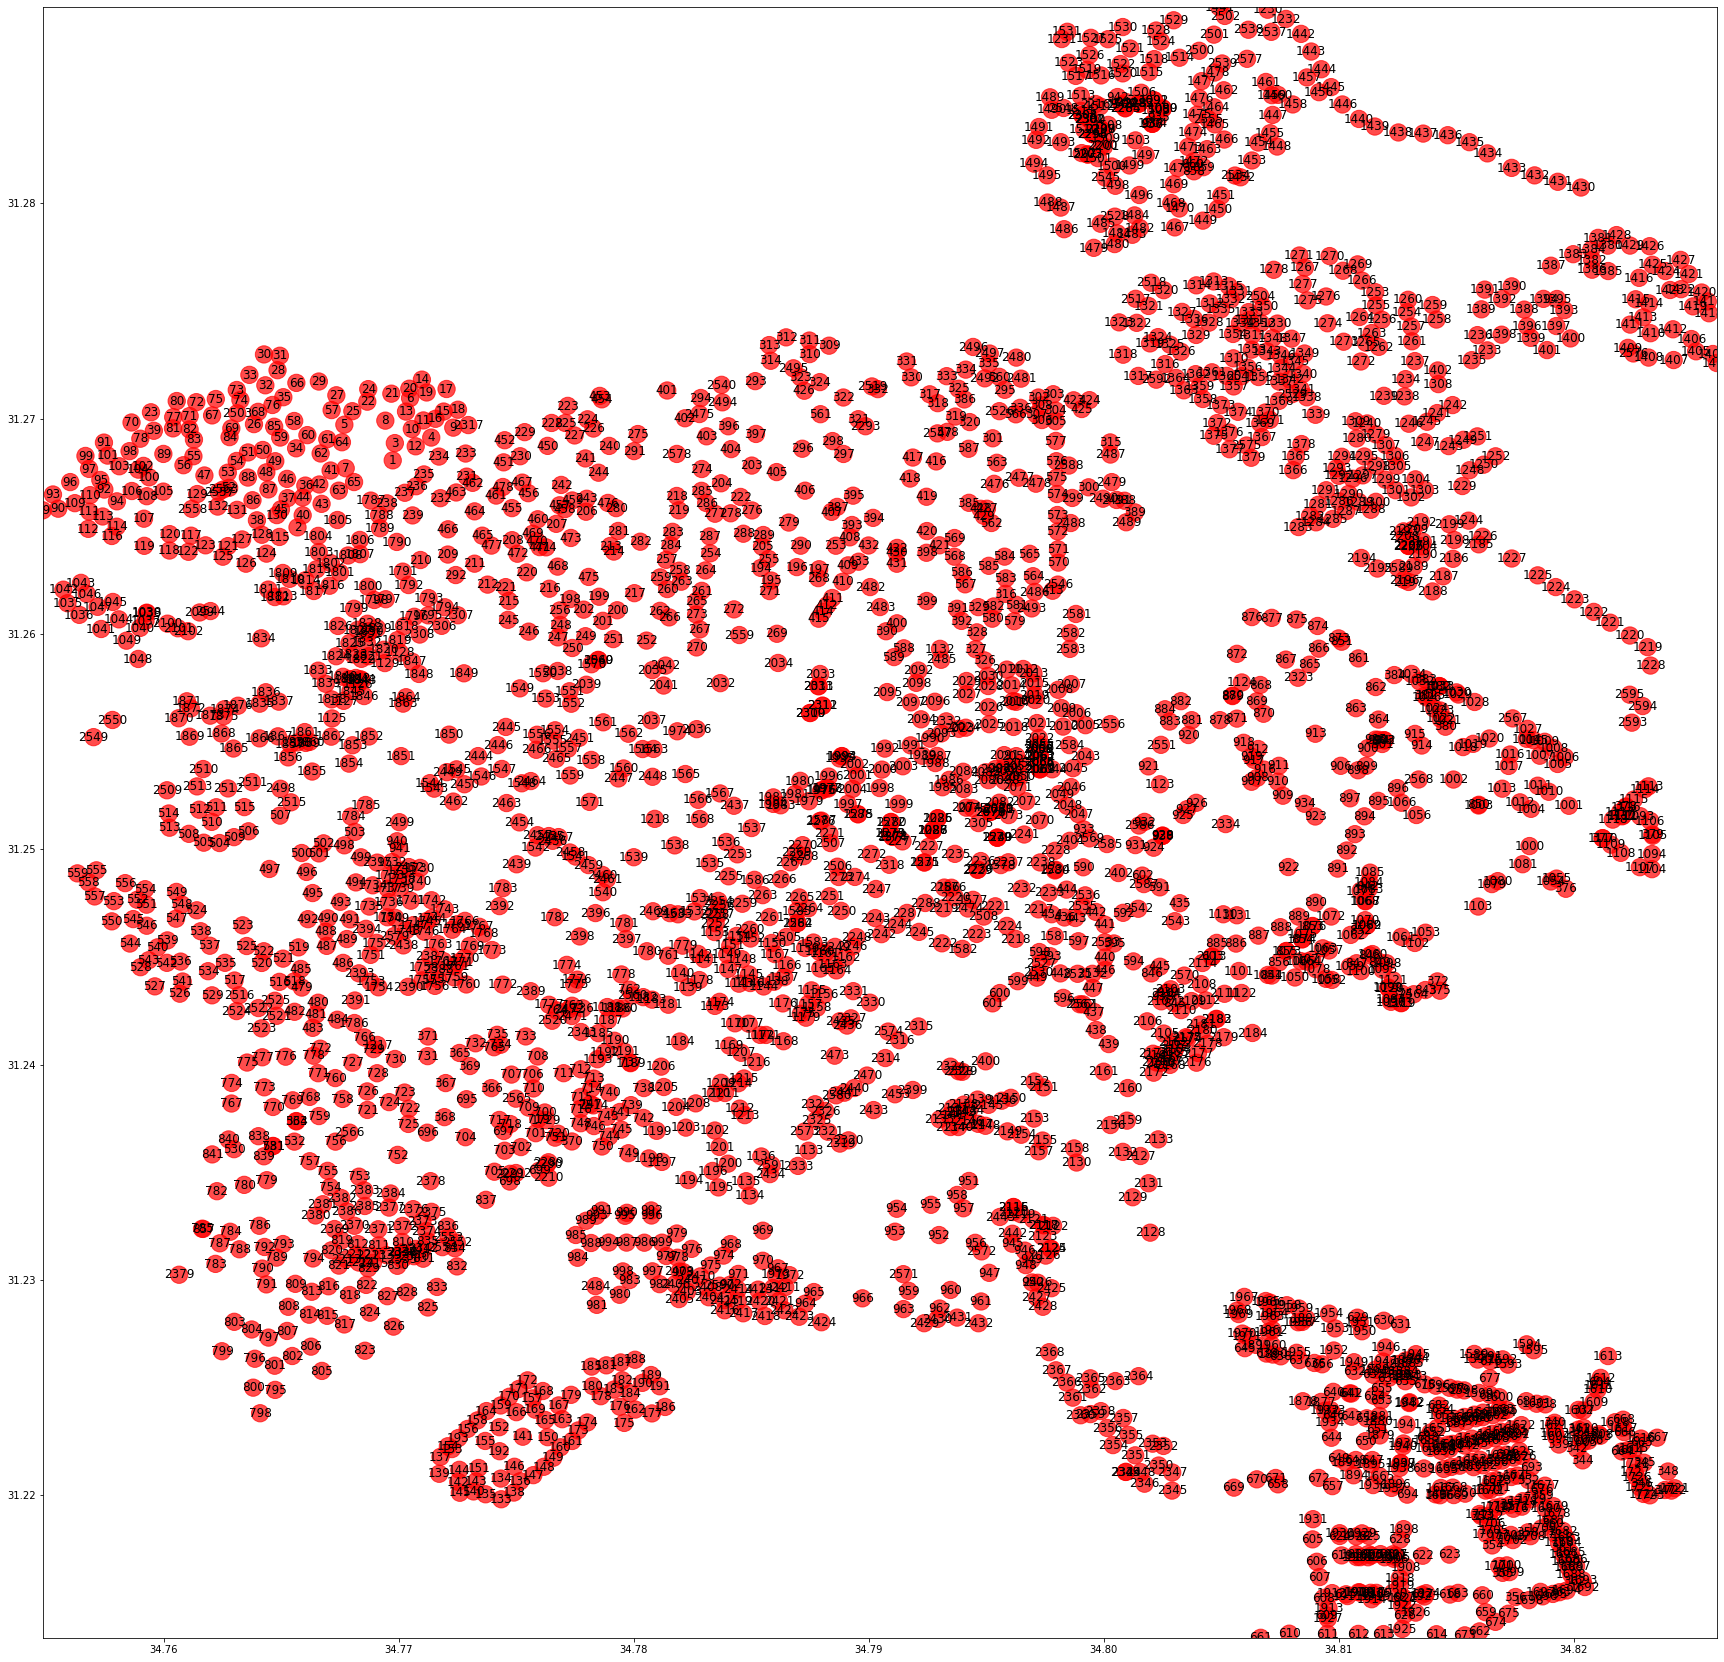

In [7]:
visualize_fire_hydrants_network();

We can see that the above network resembeles the Be'er Sheva's city layout.

### Fire hydrants networks across different thresholds (10 to 500 meters)

In [22]:
Image(url="FireHydrants.gif")

## Interesting insights - Fire hydrants
1. Around city hall in the down town area there are the least number of violations.
2. In Dalet neighborhood there are the most violations.
3. Among synagouges and educational centers there are the most violations.
4. Every python package uses langtitude and longtitude differently

# Shelters

First we show the regulations for shelters according to Home Front Command.

In [17]:
from IPython.display import Image
Image(url= "shelter.jpeg")

In the next cell we will get the objects that are isolated at least 50 meters from any shelter.

In [18]:
neighborhoods_isolated_nodes = {} # dictionary with the different neighborhoods in Be'er Sheva and the isolated objects in each of the neighborhoods
objects = ['community-centers', 'daycare', 'gas_stations', 'EducationalInstitutions', 'HealthClinics', 'Sport',
            'Synagogue']
neighborhoods = ['Alef', 'Bet', 'Gimel', 'Dalet', 'Hei', 'Vav', 'Tet', 'Ramot', 'Down Town', 'Yod Alef', 'Old Town', 'Ashan',
            'Noi Beka', 'Darom', 'Nahot']
g = create_all_graphs(objects, 'shelter', 0.05)
for neighborhood in neighborhoods:
    relevant_nodes = nodes_per_neighborhood(g, [neighborhood])
    neighborhoods_isolated_nodes[neighborhood] = len(get_isloated_nodes(g, relevant_nodes))
    
neighborhoods_df = pd.DataFrame(columns=['name', 'geometry', 'isolated_count'])
for nei_name, polygon in neighborhoods_polygons.items():
    reversed_polygon = Polygon([(v[1], v[0]) for v in list(polygon.exterior.coords)])
    neighborhoods_df = neighborhoods_df.append({'name': nei_name, 'geometry': reversed_polygon, 'isolated_count': neighborhoods_isolated_nodes[nei_name]}, ignore_index=True)

### Neighborhood polygons heatmap according violation of city regulations

The more isolated objects in a neighborhood, the brighter the nighborhood's color.

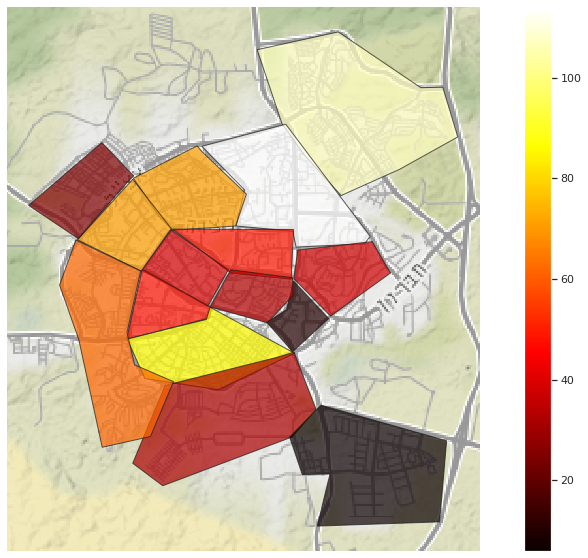

In [19]:
import contextily as ctx

def add_basemap(ax, zoom, url='http://tile.stamen.com/terrain/tileZ/tileX/tileY.png'):
    xmin, xmax, ymin, ymax = ax.axis()
    basemap, extent = ctx.bounds2img(xmin, ymin, xmax, ymax, zoom=zoom, url=url)
    ax.imshow(basemap, extent=extent, interpolation='none')
    # restore original x/y limits
    ax.axis((xmin, xmax, ymin, ymax))
    
neighborhoods_df['isolated_counts'] = neighborhoods_df['isolated_count'].astype(float)
gdf = geopandas.GeoDataFrame(neighborhoods_df, crs={'init' :'epsg:4326'}, geometry = 'geometry').to_crs(epsg=3857)
ax = gdf.plot(column='isolated_counts',figsize=(16, 10), alpha=0.7, cmap='hot',edgecolor='k', legend=True)
add_basemap(ax, zoom=12)
ax.set_axis_off()

## Display public facilities isolated from fire hydrants

In the next cell you can change, using a float slider, the (threshold) distance which we only below it we consider edges between the different objects, e.g. educational institutes to shelters. Default value is 50 meters as the regulation states.

In [20]:
distance_threshold = widgets.FloatSlider(
    min=0,
    max=500,
    step=1,
    value=50,
    description='Choose distance threshold (in meters):',
    style=style,
    layout=widgets.Layout(width='50%', height='80px'))
distance_threshold

FloatSlider(value=50.0, description='Choose distance threshold (in meters):', layout=Layout(height='80px', wid…

In the next cell you can choose the types of objects to display in the map

In [24]:
objects_ = widgets.SelectMultiple(    
    options=['community-centers', 'daycare', 'gas_stations', 'EducationalInstitutions', 'HealthClinics', 'Sport',
            'Synagogue'],
    value=['community-centers'],
    rows=7,
    description='Select types of object to display:',
    style=style,
    layout=widgets.Layout(width='40%'),
    disabled=False)
objects_


SelectMultiple(description='Select types of object to display:', index=(0,), layout=Layout(width='40%'), optio…

In the next cell you can choose the neighborhoods to display in the map

In [29]:
neighborhoods_ = widgets.SelectMultiple(    
    options=['Alef', 'Bet', 'Gimel', 'Dalet', 'Hei', 'Vav', 'Tet', 'Ramot', 'Down Town', 'Yod Alef', 'Old Town', 'Ashan',
            'Noi Beka', 'Darom', 'Nahot'],
    value=['Alef'],
    rows=11,
    description='Select neighborhoods to display the objects iny:',
    style=style,
    layout=widgets.Layout(width='40%'),
    disabled=False)
neighborhoods_

SelectMultiple(description='Select neighborhoods to display the objects iny:', index=(0,), layout=Layout(width…

In [30]:
def display_isoltaed_objects_jupyter(ev):
    """
    a function to display Folium map with interactive legend
    :param ev: env variable in notbook
    """
    clear_output()
    display(ev)
    map_ = display_isolated_objects(list(objects_.value), 'shelter', (distance_threshold.value / 1000), list(neighborhoods_.value))
    

    macro = MacroElement()
    macro._template = Template(return_template_string())

    map_.get_root().add_child(macro)
    display(map_)

In [31]:
button = widgets.Button(description="Display objects")
button.on_click(display_isoltaed_objects_jupyter)
display(button)

Button(description='Display objects', style=ButtonStyle())

## Statistics 

In this section we will present some statistics about the results of isolated objects from shelters given the Home Front Command regulations.

### All neighborhoods and all facilities according to Home Front Command regulations (50 meters)

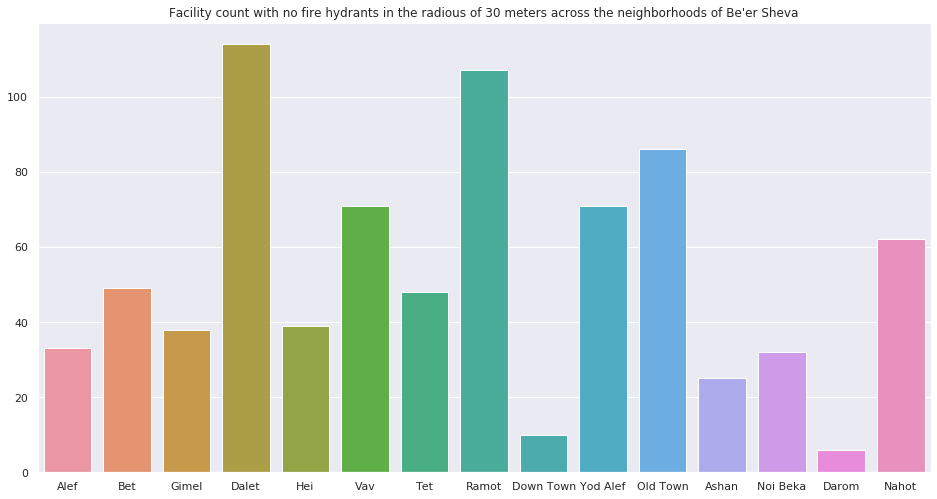

In [32]:
sns.set(rc={'figure.figsize':(16,8.27)})
sns.barplot(x=list(neighborhoods_isolated_nodes.keys()), y=list(neighborhoods_isolated_nodes.values())).set_title('Facility count with no fire hydrants in the radious of 30 meters across the neighborhoods of Be\'er Sheva');

### Isolated facility count across all neighborhoods and all facility types given a chosen threshold (from the above widget)

In [33]:
neighborhood_object_df = pd.DataFrame(columns=['neighborhood', 'object', 'count'])
for object_ in list(objects_.options):
    g = create_all_graphs([object_], 'shelter', distance_threshold.value / 1000) # 30 meters
    for neighborhood in list(neighborhoods_.options):   
        relevant_nodes = nodes_per_neighborhood(g, [neighborhood])
        neighborhood_object_df = neighborhood_object_df.append({'neighborhood': neighborhood, 'object': object_, 'count': len(get_isloated_nodes(g, relevant_nodes))}, ignore_index=True)

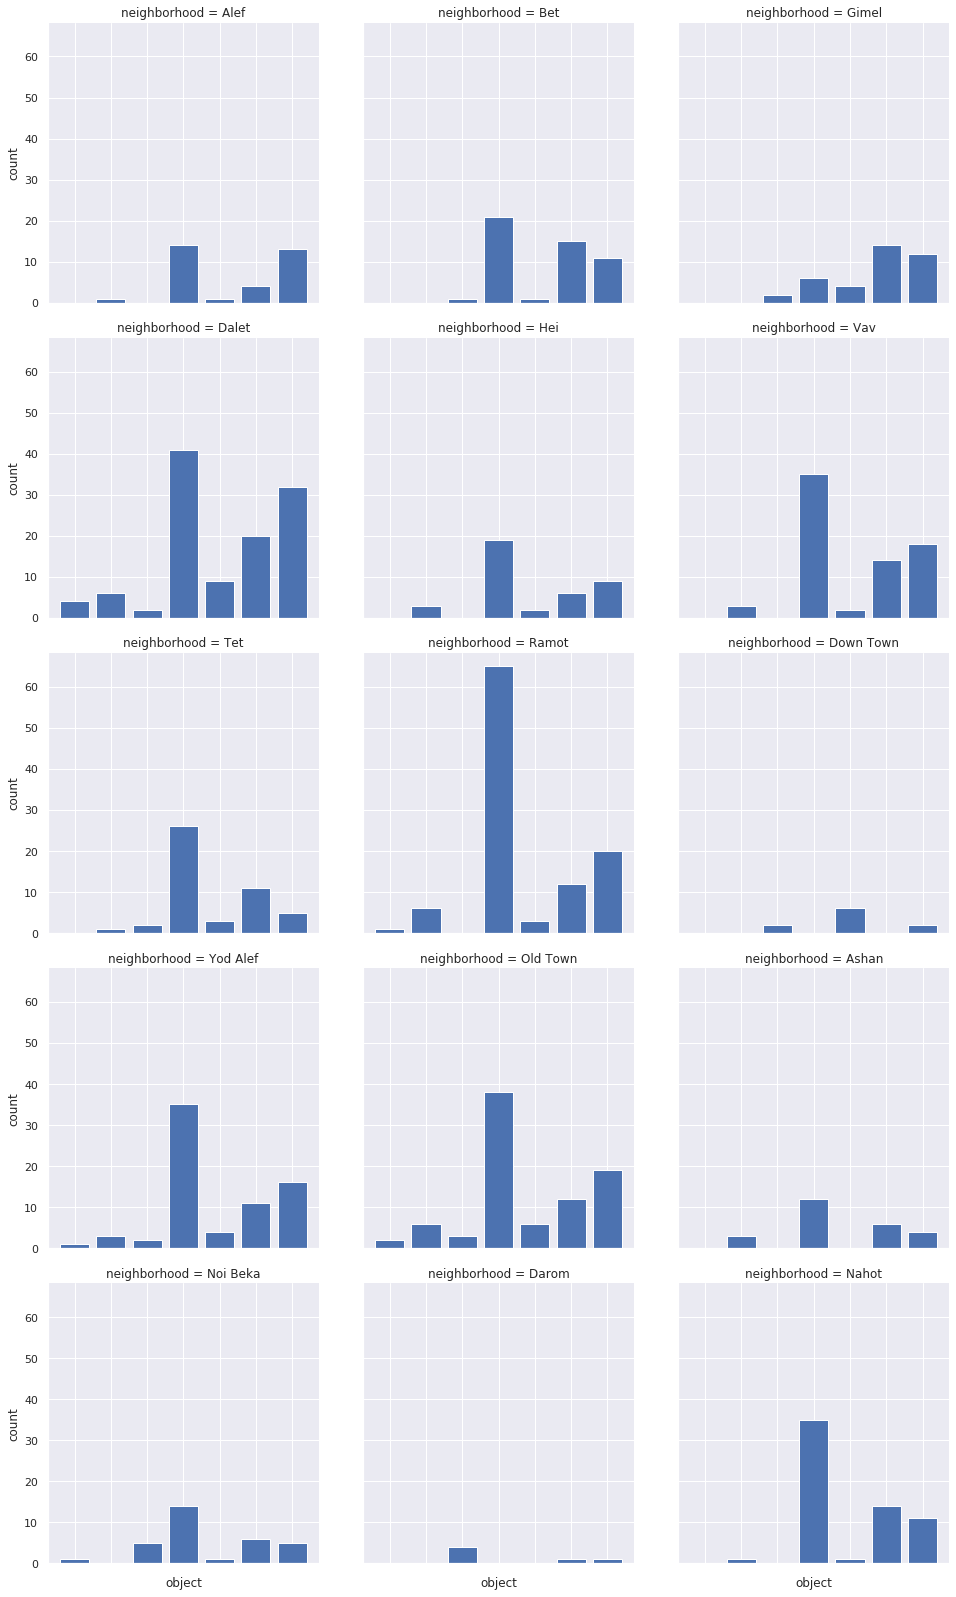

In [34]:
# facetgrid plot
g = sns.FacetGrid(neighborhood_object_df, col="neighborhood", col_wrap=3, height=4.5)
g.map(plt.bar, "object", "count")
g.fig.tight_layout()
g.set_xticklabels(rotation=45);

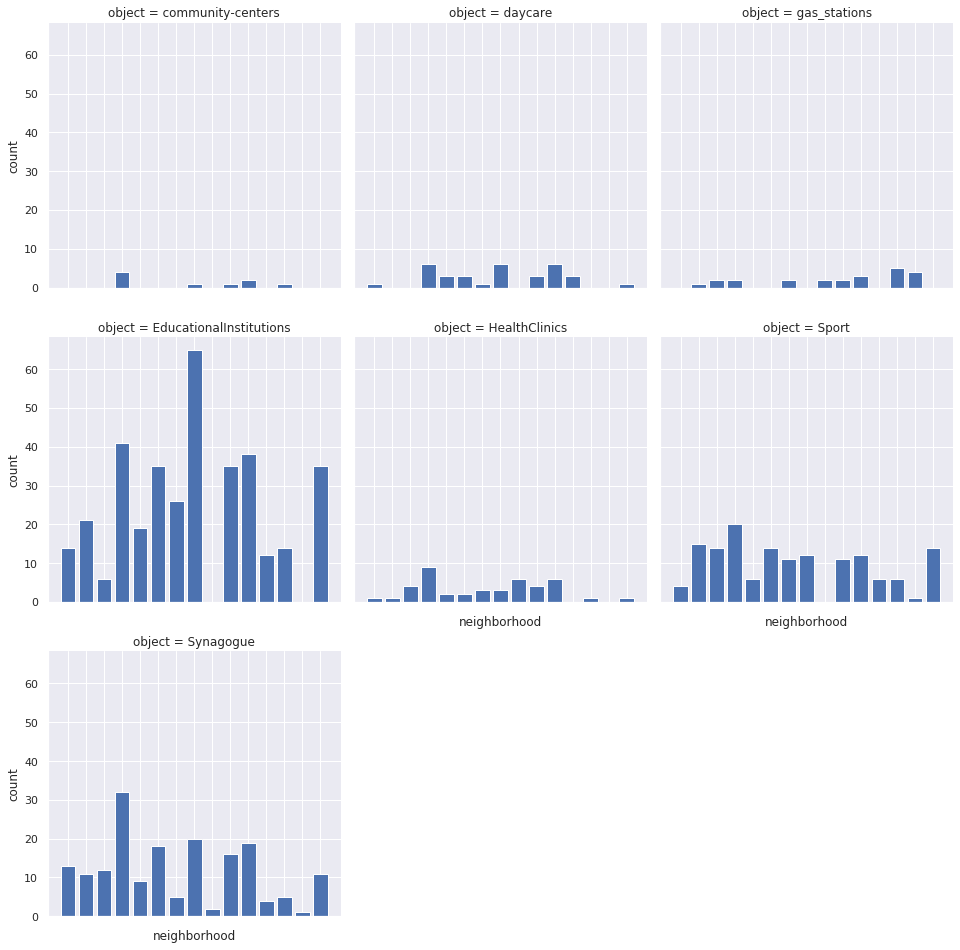

In [35]:
g = sns.FacetGrid(neighborhood_object_df, col="object", col_wrap=3, height=4.5)
g.map(plt.bar, "neighborhood", "count")
g.fig.tight_layout()
g.set_xticklabels(rotation=45);

## Heatmap of public facilities isolated from fire hydrants

**Specified by the above chosen threshold**

In [36]:
from folium.plugins import HeatMap
g = create_all_graphs(list(objects_.options), 'shelter', distance_threshold.value / 1000)
relevant_nodes = nodes_per_neighborhood(g, list(neighborhoods_.options))
isolated_list = get_isloated_nodes(g, relevant_nodes)
isolated_coordinates = [(g.nodes[node]['x'][1], g.nodes[node]['x'][0]) for node in isolated_list]
m = folium.Map(location=[31.2530, 34.7915], tiles='Stamen Terrain',
         zoom_start=13, control_scale=True, prefer_canvas=True)
HeatMap(isolated_coordinates).add_to(m)
m

## Interesting insights - Shelters

1. We can observe that the ratio of isolated objects in the different neighborhoods is similar between fire hydrants and shelters:
2. Around city hall in the down town area there are the least number of violations.
3. In Dalet and Ramot neighborhoods there is the highest number of violations.
4. The highest number of violations occur among synagouges and educational centers.